In [1]:
import math
import numpy as np
from scipy.spatial import Voronoi
from qiskit.quantum_info import SparsePauliOp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import eigvalsh
from collections import defaultdict

In [2]:
def becke_radial_grid(num_r, alpha, nu):
    # uniform grid in (0, 1)
    u = np.linspace(0.0, 1.0, num_r+2)[1:-1] # avoid u=0, and u=1 exactly

    # Becke stretching
    r = -alpha * np.log(1-u**nu)
    r = r[r>1e-3]
    return r 

In [3]:
def lebedev_6():
    # 6-point Lebedev grid
    # 精确到 l = 1
    w = 4*np.pi/6
    pts = np.array([
        [ 1, 0, 0],
        [-1, 0, 0],
        [ 0, 1, 0],
        [ 0,-1, 0],
        [ 0, 0, 1],
        [ 0, 0,-1],
    ], dtype=float)
    weights = np.full(6, w)
    return pts, weights


In [4]:
def lebedev_14():
    a = np.sqrt(1/3)
    pts = np.array([
        [ 1, 0, 0], [-1, 0, 0],
        [ 0, 1, 0], [ 0,-1, 0],
        [ 0, 0, 1], [ 0, 0,-1],
        [ a, a, a], [ a, a,-a],
        [ a,-a, a], [ a,-a,-a],
        [-a, a, a], [-a, a,-a],
        [-a,-a, a], [-a,-a,-a],
    ], dtype=float)

    w1 = 4*np.pi/21
    w2 = 4*np.pi/84
    weights = np.array([w1]*6 + [w2]*8)
    return pts, weights


In [5]:
def lebedev_26():
    a = np.sqrt(1/3)
    b = np.sqrt(3/5)
    pts = np.array([
        [ 1, 0, 0], [-1, 0, 0],
        [ 0, 1, 0], [ 0,-1, 0],
        [ 0, 0, 1], [ 0, 0,-1],
        [ a, a, a], [ a, a,-a], [ a,-a, a], [ a,-a,-a],
        [-a, a, a], [-a, a,-a], [-a,-a, a], [-a,-a,-a],
        [ b, 0, 0], [-b, 0, 0],
        [ 0, b, 0], [ 0,-b, 0],
        [ 0, 0, b], [ 0, 0,-b],
        [ 0, a, b], [ 0, a,-b], [ 0,-a, b], [ 0,-a,-b],
        [ a, 0, b], [ a, 0,-b]
    ], dtype=float)

    w1 = 4*np.pi/30
    w2 = 4*np.pi/120
    w3 = 4*np.pi/60
    weights = np.array([w1]*6 + [w2]*8 + [w3]*12)
    return pts, weights


In [6]:
def lebedev_50():
    """
    Full Lebedev 50-point spherical grid.
    Returns:
        pts: (50,3) array of unit vectors
        w:   (50,) array of weights
    """

    pts = np.array([
        [ 0.0,  0.0,  1.0],
        [ 0.0,  0.0, -1.0],
        [ 1.0,  0.0,  0.0],
        [-1.0,  0.0,  0.0],
        [ 0.0,  1.0,  0.0],
        [ 0.0, -1.0,  0.0],

        [ 0.5773502691896257,  0.5773502691896257,  0.5773502691896257],
        [ 0.5773502691896257,  0.5773502691896257, -0.5773502691896257],
        [ 0.5773502691896257, -0.5773502691896257,  0.5773502691896257],
        [ 0.5773502691896257, -0.5773502691896257, -0.5773502691896257],
        [-0.5773502691896257,  0.5773502691896257,  0.5773502691896257],
        [-0.5773502691896257,  0.5773502691896257, -0.5773502691896257],
        [-0.5773502691896257, -0.5773502691896257,  0.5773502691896257],
        [-0.5773502691896257, -0.5773502691896257, -0.5773502691896257],

        [ 0.0,  0.5257311121191336,  0.85065080835204],
        [ 0.0,  0.5257311121191336, -0.85065080835204],
        [ 0.0, -0.5257311121191336,  0.85065080835204],
        [ 0.0, -0.5257311121191336, -0.85065080835204],

        [ 0.5257311121191336,  0.85065080835204,  0.0],
        [ 0.5257311121191336, -0.85065080835204,  0.0],
        [-0.5257311121191336,  0.85065080835204,  0.0],
        [-0.5257311121191336, -0.85065080835204,  0.0],

        [ 0.85065080835204,  0.0,  0.5257311121191336],
        [ 0.85065080835204,  0.0, -0.5257311121191336],
        [-0.85065080835204,  0.0,  0.5257311121191336],
        [-0.85065080835204,  0.0, -0.5257311121191336],

        [ 0.30901699437494745,  0.5,  0.8090169943749475],
        [ 0.30901699437494745,  0.5, -0.8090169943749475],
        [ 0.30901699437494745, -0.5,  0.8090169943749475],
        [ 0.30901699437494745, -0.5, -0.8090169943749475],
        [-0.30901699437494745,  0.5,  0.8090169943749475],
        [-0.30901699437494745,  0.5, -0.8090169943749475],
        [-0.30901699437494745, -0.5,  0.8090169943749475],
        [-0.30901699437494745, -0.5, -0.8090169943749475],

        [ 0.5,  0.8090169943749475,  0.30901699437494745],
        [ 0.5,  0.8090169943749475, -0.30901699437494745],
        [ 0.5, -0.8090169943749475,  0.30901699437494745],
        [ 0.5, -0.8090169943749475, -0.30901699437494745],
        [-0.5,  0.8090169943749475,  0.30901699437494745],
        [-0.5,  0.8090169943749475, -0.30901699437494745],
        [-0.5, -0.8090169943749475,  0.30901699437494745],
        [-0.5, -0.8090169943749475, -0.30901699437494745],

        [ 0.8090169943749475,  0.30901699437494745,  0.5],
        [ 0.8090169943749475,  0.30901699437494745, -0.5],
        [ 0.8090169943749475, -0.30901699437494745,  0.5],
        [ 0.8090169943749475, -0.30901699437494745, -0.5],
        [-0.8090169943749475,  0.30901699437494745,  0.5],
        [-0.8090169943749475,  0.30901699437494745, -0.5],
        [-0.8090169943749475, -0.30901699437494745,  0.5],
        [-0.8090169943749475, -0.30901699437494745, -0.5],
    ])

    # 权重（全部 50 个）
    w = np.array([
        0.126984126984127, 0.126984126984127,
        0.126984126984127, 0.126984126984127,
        0.126984126984127, 0.126984126984127,

        0.047619047619048, 0.047619047619048,
        0.047619047619048, 0.047619047619048,
        0.047619047619048, 0.047619047619048,
        0.047619047619048, 0.047619047619048,

        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
        0.075, 0.075, 0.075, 0.075,
    ])

    return pts, w


In [7]:
def lebedev_74():
    """
    Full Lebedev 74-point spherical grid.
    Returns:
        pts: (74,3) array of unit vectors
        w:   (74,) array of weights
    """

    a = 0.45970084338098305
    b = 0.6285393610547089
    c = 0.322185354626569
    d = 0.8360955967490217

    pts = np.array([
        [ 0.0,  0.0,  1.0],
        [ 0.0,  0.0, -1.0],
        [ 1.0,  0.0,  0.0],
        [-1.0,  0.0,  0.0],
        [ 0.0,  1.0,  0.0],
        [ 0.0, -1.0,  0.0],

        [ a,  a,  a], [ a,  a,-a], [ a,-a,  a], [ a,-a,-a],
        [-a,  a,  a], [-a,  a,-a], [-a,-a,  a], [-a,-a,-a],

        [ b,  0,  c], [ b,  0,-c], [-b,  0,  c], [-b,  0,-c],
        [ 0,  b,  c], [ 0,  b,-c], [ 0,-b,  c], [ 0,-b,-c],
        [ c,  b,  0], [ c,-b,  0], [-c,  b,  0], [-c,-b,  0],

        [ d,  d,  0], [ d,-d,  0], [-d,  d,  0], [-d,-d,  0],
        [ d,  0,  d], [ d,  0,-d], [-d,  0,  d], [-d,  0,-d],
        [ 0,  d,  d], [ 0,  d,-d], [ 0,-d,  d], [ 0,-d,-d],

        [ 0.0,  a,  b], [ 0.0,  a,-b], [ 0.0,-a,  b], [ 0.0,-a,-b],
        [ a,  0.0,  b], [ a,  0.0,-b], [-a,  0.0,  b], [-a,  0.0,-b],
        [ b,  a,  0.0], [ b,-a,  0.0], [-b,  a,  0.0], [-b,-a,  0.0],

        [ c,  c,  d], [ c,  c,-d], [ c,-c,  d], [ c,-c,-d],
        [-c,  c,  d], [-c,  c,-d], [-c,-c,  d], [-c,-c,-d],

        [ d,  c,  c], [ d,  c,-c], [ d,-c,  c], [ d,-c,-c],
        [-d,  c,  c], [-d,  c,-c], [-d,-c,  c], [-d,-c,-c],

        [ c,  d,  c], [ c,  d,-c], [ c,-d,  c], [ c,-d,-c],
        [-c,  d,  c], [-c,  d,-c], [-c,-d,  c], [-c,-d,-c],
    ])

    w1 = 0.047619047619047616
    w2 = 0.0380952380952381
    w3 = 0.03214285714285714
    w4 = 0.02857142857142857

    w = np.array(
        [w1]*6 +
        [w2]*8 +
        [w3]*12 +
        [w4]*48
    )

    return pts, w


In [8]:
def lebedev_86():
    """
    Full Lebedev 86-point spherical grid.
    Returns:
        pts: (86,3) array of unit vectors
        w:   (86,) array of weights
    """

    a = 0.2666354015167047
    b = 0.681507726536546
    c = 0.4174961227965453
    d = 0.872473431981953

    pts = np.array([
        [ 0.0,  0.0,  1.0],
        [ 0.0,  0.0, -1.0],
        [ 1.0,  0.0,  0.0],
        [-1.0,  0.0,  0.0],
        [ 0.0,  1.0,  0.0],
        [ 0.0, -1.0,  0.0],

        [ a,  a,  a], [ a,  a,-a], [ a,-a,  a], [ a,-a,-a],
        [-a,  a,  a], [-a,  a,-a], [-a,-a,  a], [-a,-a,-a],

        [ b,  0,  c], [ b,  0,-c], [-b,  0,  c], [-b,  0,-c],
        [ 0,  b,  c], [ 0,  b,-c], [ 0,-b,  c], [ 0,-b,-c],
        [ c,  b,  0], [ c,-b,  0], [-c,  b,  0], [-c,-b,  0],

        [ d,  d,  0], [ d,-d,  0], [-d,  d,  0], [-d,-d,  0],
        [ d,  0,  d], [ d,  0,-d], [-d,  0,  d], [-d,  0,-d],
        [ 0,  d,  d], [ 0,  d,-d], [ 0,-d,  d], [ 0,-d,-d],

        [ 0.0,  a,  b], [ 0.0,  a,-b], [ 0.0,-a,  b], [ 0.0,-a,-b],
        [ a,  0.0,  b], [ a,  0.0,-b], [-a,  0.0,  b], [-a,  0.0,-b],
        [ b,  a,  0.0], [ b,-a,  0.0], [-b,  a,  0.0], [-b,-a,  0.0],

        [ c,  c,  d], [ c,  c,-d], [ c,-c,  d], [ c,-c,-d],
        [-c,  c,  d], [-c,  c,-d], [-c,-c,  d], [-c,-c,-d],

        [ d,  c,  c], [ d,  c,-c], [ d,-c,  c], [ d,-c,-c],
        [-d,  c,  c], [-d,  c,-c], [-d,-c,  c], [-d,-c,-c],

        [ c,  d,  c], [ c,  d,-c], [ c,-d,  c], [ c,-d,-c],
        [-c,  d,  c], [-c,  d,-c], [-c,-d,  c], [-c,-d,-c],
    ])

    w1 = 0.0380952380952381
    w2 = 0.03214285714285714
    w3 = 0.02857142857142857
    w4 = 0.025396825396825397

    w = np.array(
        [w1]*6 +
        [w2]*8 +
        [w3]*12 +
        [w4]*60
    )

    return pts, w


In [9]:
def lebedev_grid(order):
    """
    Return Lebedev directions (unit vectors) and weights for a given order.
    order: one of {6, 14, 26, 38, 50, 74, 86, 110, 146, 170, 194, 230, 266, 302, 350}
    """
    if order == 6:
        return lebedev_6()
    elif order == 14:
        return lebedev_14()
    elif order == 26:
        return lebedev_26()
    elif order == 50:
        return lebedev_50()
    elif order == 74:
        return lebedev_74()
    elif order == 86:
        return lebedev_86()
    else:
        raise ValueError(f"Lebedev order {order} not implemented.")


In [10]:
# 3D adaptive grid for hydrogen using Lebedev 2025 12 21

def hydrogen_adaptive_grid_lebedev(num_r, order):
    # For the time being, we test the radial part via exponential stretch like r^1.5
    #r = np.linspace(0.1, r_max, num_r)**1.5
    alpha=1.0
    nu=2.0
    r = becke_radial_grid(num_r, alpha, nu)

    r = r[r > 1e-3]
    
    leb_pts, leb_w = lebedev_grid(order)
    points = []
    for ri in r:
        for n in leb_pts:
            points.append(ri * n)

    points = np.array(points)
    #vor = Voronoi(points, qhull_options='Qbb Qc Qx QJ')
    vor = Voronoi(points, qhull_options='QJ')
    
    neighbors = {i: set() for i in range(len(points))}            
    for p, q in vor.ridge_points:
        neighbors[p].add(q)
        neighbors[q].add(p)
    for m in range(len(points)):
        for n in neighbors[m]:
            if m not in neighbors[n]:
                print("Asym neighbor:", m, n)
    return np.array(points), neighbors, vor

In [11]:
# 6, 14, 26, 50, 74, 86
points, neighbors, vor = hydrogen_adaptive_grid_lebedev(num_r=20, order = 50)

In [12]:
# 3D adaptive grid for hydrogen

import numpy as np

def hydrogen_adaptive_grid(num_r, num_theta, num_phi, r_max):
    # For the time being, we test the radial part via exponential stretch like r^1.5
    #r = np.linspace(0.1, r_max, num_r)**1.5
    alpha=1.0
    nu=2.0
    r = becke_radial_grid(num_r, alpha, nu)

    r = r[r > 1e-3]
    
    theta = np.linspace(0.2, np.pi-0.2, num_theta)
    phi = np.linspace(0, 2*np.pi, num_phi, endpoint=False)

    points = []
    for ri in r:
        for th in theta:
            for ph in phi:
                x = ri * np.sin(th) * np.cos(ph)
                y = ri * np.sin(th) * np.sin(ph)
                z = ri * np.cos(th)
                points.append([x, y, z])
                
    #vor = Voronoi(points, qhull_options='Qbb Qc Qx QJ')
    vor = Voronoi(points, qhull_options='QJ')
    
    neighbors = {i: set() for i in range(len(points))}            
    for p, q in vor.ridge_points:
        neighbors[p].add(q)
        neighbors[q].add(p)
    for m in range(len(points)):
        for n in neighbors[m]:
            if m not in neighbors[n]:
                print("Asym neighbor:", m, n)
    return np.array(points), neighbors, vor

points, neighbors, vor = hydrogen_adaptive_grid(num_r=30, num_theta=8, num_phi=16, r_max=5.0)

In [12]:
# calculate the geometrical properties of facet
def facet_geometry(vor, ridge_vertices):
    verts = vor.vertices[ridge_vertices]

    # normal
    v1 = verts[1] - verts[0]
    v2 = verts[2] - verts[0]
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)

    # centroid
    centroid = verts.mean(axis = 0)

    # area (shoelace)

    # Project polygon onto the plane where hte normal has the smallest component 
    # (this avoids degeneracy)
    ax = np.argmin(np.abs(normal))
    proj = np.delete(verts, ax, axis=1)

    # Compute 2D polygon area using shoelace formula
    x = proj[:, 0]
    y = proj[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) -np.dot(y, np.roll(x, -1)))
    
    return normal, centroid, area

In [13]:
# Calculate the facet areas
def facet_area(vor, ridge_vertices):
    if -1 in ridge_vertices:
        return np.inf # facet in infinity

    verts = vor.vertices[ridge_vertices]
    
    normal, _ = facet_geometry(vor, ridge_vertices)

    # Project polygon onto the plane where hte normal has the smallest component 
    # (this avoids degeneracy)
    ax = np.argmin(np.abs(normal))
    proj = np.delete(verts, ax, axis=1)

    # Compute 2D polygon area using shoelace formula
    x = proj[:, 0]
    y = proj[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, -1)) -np.dot(y, np.roll(x, -1)))
    return area

In [14]:
# Calculate Voronoi cell volumes
def cell_volume(vor, points, neighbors):
    sigma = {} # dictionary of dictionaries, to hold the information of area
    normals = {} # to hold the imformation of normal
    centroids = {} # to hold the information of centroid of a facet
    volumes = [0.0] * len(points)

    
    # This loop is to set up the dictionaries of sigma, normals and centroids
    for (p, q), rv in zip(vor.ridge_points, vor.ridge_vertices):
        # skip infinite facets
        if -1 in rv:
            continue
            
        normal, centroid, area = facet_geometry(vor, rv)
        normals.setdefault(p, {})[q] = normal
        normals.setdefault(q, {})[p] = normal
        centroids.setdefault(p, {})[q] = centroid
        centroids.setdefault(q, {})[p] = centroid
        sigma.setdefault(p, {})[q] = area
        sigma.setdefault(q, {})[p] = area

    for m in range(len(points)):
        r_m = points[m]
        volume_m = 0.0

        for n in neighbors[m]:

            # skip missing facets (infinite or degenerate)
            if n not in sigma.get(m, {}):
                continue
                
            area = sigma[m][n]
            normal = normals[m][n]
            centroid = centroids[m][n]

            height = abs(np.dot(normal, centroid - r_m))
            volume_m += area * height / 3.0
            
        volumes[m] = volume_m
 
    return sigma, volumes
    

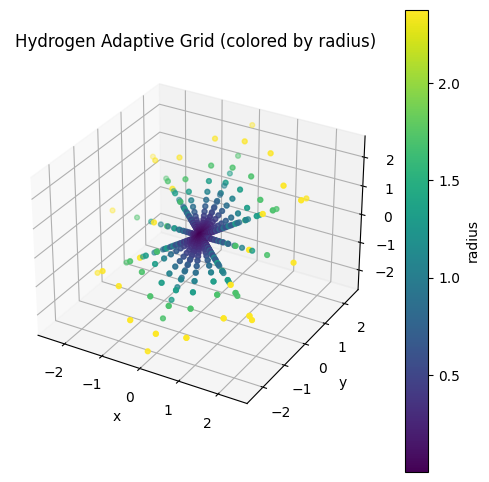

In [15]:
# Plot the 3d hydrogen points
import matplotlib.pyplot as plt


#points = hydrogen_adaptive_grid()

r = np.linalg.norm(points, axis = 1)

fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(points[:,0], points[:,2], points[:, 2], c=r, cmap='viridis', s=12)
fig.colorbar(p, ax=ax, label='radius')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Hydrogen Adaptive Grid (colored by radius)')

plt.show()

In [16]:
# Laplacian matrix from (15)
# import math
def lapl_matr(vor, points, neighbors):
    sigma, volumes = cell_volume(vor, points, neighbors)
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits

    # initialize Laplacian matrix
    lapl = [[0.0]*dim for _ in range(dim)]

    for m in range(length):
        r_m = points[m]

        # diagonal term
        diag_sum = 0.0
        for k in neighbors[m]:
            if k not in sigma[m]:
                continue
            dist = np.linalg.norm(points[m] - points[k])
            diag_sum += sigma[m][k] / dist

        lapl[m][m] = -diag_sum / volumes[m]
        #lapl[m][m] = -diag_sum / np.sqrt(volumes[m]*volumes[n])

       # off-diagonal terms
        for n in neighbors[m]:
            if n not in sigma[m]:
                continue
            dist = np.linalg.norm(points[m] - points[n])
            lapl[m][n] = sigma[m][n] / (np.sqrt(volumes[m]*volumes[n]) * dist)
            # Expression above is from the Eqn. (21)
            #lapl[n][m] = sigma[n][m]/ (volumes[n] * dist)
   # print("max asymmetry:", max(abs(lapl[m][n] - lapl[n][m]) for m in range(100) for n in range(100)))
   # print("row sums:", [sum(lapl[m]) for m in range(10)])
#    for m in range(length):
#        for n in neighbors[m]:
#            if n not in sigma[m]:
#                continue
#            dist = np.linalg.norm(points[m] - points[n])
#            w = sigma[m][n] / dist 

#            lapl[m][n] = -w
#            lapl[n][m] = -w

#            lapl[m][m] += w
#            lapl[n][n] += w

    return lapl


In [17]:
# Coulombic electron-nuclei attraction
# For hydrogen atom, we set the nuclear at the origin
# Therefore, \vec{R}_{\alpha}=\vec{0} and Z_{\alpha}=1
def coulombic_potential(points):
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits
    ele_nu = [0.0] * dim
    ele_ele = [[0.0]*dim for _ in range(dim)]

    Z_alpha = 1.0
    R_alpha = np.array([0.0, 0.0, 0.0])

    # electron–nucleus attraction
    for m in range(length):
        dist_nucl = np.linalg.norm(points[m] - R_alpha)
        if dist_nucl == 0:
            ele_nu[m] = np.inf
        else:
            ele_nu[m] = -Z_alpha / dist_nucl   # negative sign is important

    # electron–electron repulsion
    for m in range(length):
        for p in range(m, length):
            if m == p:
                ele_ele[m][p] = 0.0
            else:
                dist = np.linalg.norm(points[m] - points[p])
                ele_ele[m][p] = 1.0 / dist
                ele_ele[p][m] = ele_ele[m][p]  # symmetry

    return ele_nu, ele_ele


In [18]:
# The following code is for the eqn. (21) 
# 2025-12-29
def t_bar_matr(vor, points, neighbors): 
    lapl = lapl_matr(vor, points, neighbors)
    ele_nu, ele_ele = coulombic_potential(points)
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits

    t_bar = [[0.0]*dim for _ in range(dim)]
    for m in range(length):
        t_bar[m][m] = -ele_nu[m]
        for n in range(length):
            t_bar[m][n] = t_bar[m][n]-lapl[m][n]*0.5

    return t_bar

In [19]:
# This function is to realize bitwise dot
# 2025-12-29
def bitwise_dot(m, n, num_bits):
    """Return the bitwise dot product (mod 2) of m and n."""
    s = 0
    for b in range(num_bits):
        s ^= ((m >> b) & 1) & ((n >> b) & 1)
    return s



In [20]:
# This function is for bitwise xor
# 2025-12-29
def bitwise_xor(m, n, num_bits):
    """Return the bitwise XOR of m and n, restricted to num_bits bits."""
    mask = (1 << num_bits) - 1
    return (m ^ n) & mask


In [21]:
def int_to_bits(x, num_bits):
    return [(x >> b) & 1 for b in range(num_bits)]


In [22]:

def omega_matr(vor, points, neighbors):
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits   # = 2^num_bits

    # 1. 构造扩展后的 t_bar
    t_bar_small = t_bar_matr(vor, points, neighbors)
    t_bar = [[0.0]*dim for _ in range(dim)]
    for i in range(length):
        for j in range(length):
            t_bar[i][j] = t_bar_small[i][j]

    # 2. 构造 omega
    omega = [[0.0]*dim for _ in range(dim)]
    for m in range(dim):
        for n in range(dim):
            s = 0.0
            for x in range(dim):
                phase = bitwise_dot(x, n, num_bits)  # must be mod 2
                label = bitwise_xor(m, x, num_bits)
                s += ((-1)**phase) * t_bar[label][x]
            omega[m][n] = s / dim

    return omega

            

In [23]:
# The following code is to realize the Hadamard butterfly so that the
# Fast Wals-Hadamard Transformation (FWHT) can be realized in this 
# function
def fwht(a):
    n = len(a)
    h = 1
    while h < n:
        for i in range(0, n, h*2):
            for j in range(i, i+h):
                x = a[j]
                y = a[j+h]
                a[j]   = x + y
                a[j+h] = x - y
        h *= 2


In [ ]:
# The following function is used to take the place of 
# omega_matr(vor, points, neighbors) so that the FWHT
# can be used to improve the effeciency
# 2026, 01, 24
def omega_matr_fwht(vor, points, neighbors):
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits

    # 1. 构造扩展后的 t_bar
    t_bar_small = t_bar_matr(vor, points, neighbors)
    t_bar = [[0.0]*dim for _ in range(dim)]
    for i in range(length):
        for j in range(length):
            t_bar[i][j] = t_bar_small[i][j]

    # 2. 构造 omega
    omega = [[0.0]*dim for _ in range(dim)]

    # 对每个 m 做一次 1D FWHT
    for m in range(dim):
        # Step 1: 构造 f_m(x)
        a = [0.0]*dim
        for x in range(dim):
            label = m ^ x
            a[x] = t_bar[label][x]

        # Step 2: 对 a 做 FWHT
        fwht(a)

        # Step 3: 写入 omega[m][n]
        for n in range(dim):
            omega[m][n] = a[n] / dim

    return omega


In [29]:
def omega_prime_matr(vor, points, neighbors):
    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits
    #omega = omega_matr(vor, points, neighbors)
    omega = omega_matr_fwht(vor, points, neighbors)
    omega_prime = [[0.0]*dim for _ in range(dim)]

    for m in range(dim):
        for n in range(dim):
            if m==0 and n==0:
                omega_prime[m][n] = 0
            else:
                omega_prime[m][n] = omega[m][n]
            #For the time being, since we are studing single electron system
            #gamma equals to zero, we have omega equals to omega_prime except
            #for the very first entry.
    return omega_prime

In [26]:
# Coulombic electron-nuclei attraction
# For hydrogen atom, we set the nuclear at the origin
# Therefore, \vec{R}_{\alpha}=\vec{0} and Z_{\alpha}=1
def ne_coulombic_potential(points, eta):
    length = len(points)
    ele_nu = [0.0] * length
    ele_ele = [[0.0]*length for _ in range(length)]

    Z_alpha = 1.0
    R_alpha = np.array([0.0, 0.0, 0.0])

    # electron–nucleus attraction
    for m in range(length):
        dist_nucl = np.linalg.norm(points[m] - R_alpha)
        if dist_nucl == 0:
            ele_nu[m] = np.inf
        else:
            ele_nu[m] = -Z_alpha / dist_nucl   # negative sign is important

    # electron–electron repulsion
    for m in range(length):
        for p in range(m, length):
            if m == p:
                ele_ele[m][p] = 0.0
            else:
                dist = np.linalg.norm(points[m] - points[p])
                ele_ele[m][p] = 1.0 / dist
                ele_ele[p][m] = ele_ele[m][p]  # symmetry

    return ele_nu, ele_ele


In [27]:
# For the time being, let me establish Hamiltonian via (14) for hydrogen 2025 12 16
def hamilton_14(vor, points, neighbors):
    length = len(points)
    ham = [[0.0]*length for _ in range(length)]
    lapl = lapl_matr(vor, points, neighbors) # Calculate the Laplacian
    ele_nu, ele_ele = coulombic_potential(points)
    for m in range(length):
        for n in range(length):
            ham[m][n] = -0.5*lapl[m][n]

    for m in range(length):
        ham[m][m] += ele_nu[m]
    return ham

In [28]:
import numpy as np
ham = hamilton_14(vor, points, neighbors)
H = np.array(ham)
vals, vecs = np.linalg.eigh(H)
print(vals[0])


-0.7998190768711567


In [28]:
%%script false
# Use sparse matrix linear algebra method to obtain first value of the spectrum 2025 12 20
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh # eigenvalue for sparse matrix

def hamilton_sparse(vor, points, neighbors):
    lapl = lapl_matr(vor, points, neighbors)
    ele_nu, ele_ele = coulombic_potential(points)

    N = len(points)
    H = lil_matrix((N, N))

    for m in range(N):
        for n in range(N):
            if lapl[m][n] != 0.0:
                H[m, n] += -0.5 * lapl[m][n]
        H[m, m] += ele_nu[m]

    return H.tocsr()

Couldn't find program: 'false'


H = hamilton_sparse(vor, points, neighbors)

# Figue out the least 5 eigenvalues, including the ground state
vals, vecs = eigsh(H, k=5, which='SA', ncv = 50, maxiter=200000)   # SA = smallest algebraic

E0 = vals[0]
print("Ground state:", E0)


In [30]:
def pauli_string_from_mn(m, n, num_bits):
    bits_m = int_to_bits(m, num_bits)
    bits_n = int_to_bits(n, num_bits)

    pauli_ops = []
    for b in range(num_bits):
        mb = bits_m[b]
        nb = bits_n[b]

        if mb == 0 and nb == 0:
            pauli_ops.append("I")
        elif mb == 1 and nb == 0:
            pauli_ops.append("X")
        elif mb == 0 and nb == 1:
            pauli_ops.append("Z")
        elif mb == 1 and nb == 1:
            pauli_ops.append("Y")  # XZ = ±iY，忽略全局相位即可

    # Qiskit uses MSB→LSB, so reverse
    return "".join(pauli_ops[::-1])


In [31]:
# This function is to realize the expression 26 in the paper
# For the time being, for the single electron system, we only
# need to consider the first term.
# 2026, 01, 02
#from qiskit.quantum_info import SparsePauliOp

def Hbar_LCU(vor, points, neighbors):

    length = len(points)
    num_bits = math.ceil(math.log2(length))
    dim = 1 << num_bits   # = 2^num_bits

    # 1. compute ω'_{mn} (N×N)
    #coeff_small = omega_prime_matr(vor, points, neighbors)
    coeff = omega_prime_matr(vor, points, neighbors)

    # 2. extend to 2^num_bits × 2^num_bits
    #coeff = np.zeros((dim, dim))
    #coeff[:length, :length] = coeff_small

    pauli_list = []
    coeff_list = []

    # 3. build Pauli expansion
    for m in range(dim):
        for n in range(dim):
            coeff_elem = coeff[m][n]
            if abs(coeff_elem) < 1e-12:
                continue  # skip zero terms

            Pmn = pauli_string_from_mn(m, n, num_bits)
            pauli_list.append(Pmn)
            coeff_list.append(coeff_elem)

    # 4. construct SparsePauliOp
    H = SparsePauliOp(pauli_list, coeff_list)

    return H


In [32]:
# 测试数据
#vor = None
#points = [(0,0), (1,0), (0,1), (1,1)]  # N=4 示例
#neighbors = None

H = Hbar_LCU(vor, points, neighbors)
#print("num_qubits:", H.num_qubits)
#print("Pauli terms:", len(H.paulis))
#print(H)  # 打印 Pauli 展开
# 可选：对角化比较（小系统）
#Hmat = H.to_matrix()
#evals, _ = np.linalg.eigh(Hmat)
#print("Exact eigenvalues:", np.sort(evals.real))


In [33]:
Hmat = H.to_matrix()
evals, _ = np.linalg.eigh(Hmat)
print("Exact eigenvalues:", np.sort(evals.real))

Exact eigenvalues: [-309167.75954572 -178351.0461813  -102028.37902788 ... 2542195.49463108
 2659391.84976945 2673109.97163832]


In [ ]:
coeff_small = omega_prime_matr(vor, points, neighbors)

print("type(coeff_small):", type(coeff_small))
# 如果是 numpy array，打印 dtype 和 shape
if isinstance(coeff_small, np.ndarray):
    print("ndarray dtype:", coeff_small.dtype, "shape:", coeff_small.shape)
else:
    # 如果是 list/tuple 等，打印长度和第一个元素类型
    try:
        print("len:", len(coeff_small))
    except Exception as e:
        print("not sized container:", e)

# 打印 repr 的前几字符，帮助判断是不是字符串或其它对象
print("repr head:", repr(coeff_small)[:400])

# 如果是可迭代的二维结构，打印前几项的类型和值样例
try:
    for i, row in enumerate(coeff_small):
        if i >= 6:
            break
        print(f"row {i} type:", type(row), "repr:", repr(row)[:200])
        # 如果 row 是可迭代，打印前几个元素类型和值
        try:
            for j, val in enumerate(row):
                if j >= 6:
                    break
                print("  ", i, j, type(val), repr(val))
        except Exception:
            pass
except Exception:
    pass


top 1 terms capture 4.4852% of squared-norm
top 5 terms capture 21.7423% of squared-norm
top 10 terms capture 40.1669% of squared-norm
top 50 terms capture 76.2579% of squared-norm
top 100 terms capture 80.2556% of squared-norm
n_terms: 179711
coeff dtype: complex128
max |coeff|: 69016.00603194011
min |coeff| (nonzero): 1.284429057134836e-12
median |coeff|: 0.023913610522239163
mean |coeff|: 89.00878724730377
std |coeff|: 763.5545862981072


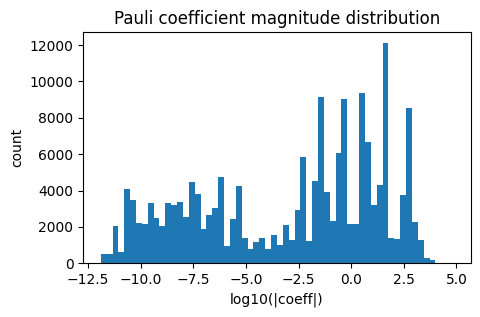

In [47]:
coeffs = np.array(H.coeffs) # Qiskit: SparsePauliOp.coeffs
paulis = H.paulis # Qiskit: SparsePauliOp.paulis (Pauli strings)
abs_coeffs = np.abs(coeffs)

# 1. 累积范数贡献（按绝对值排序）
order = np.argsort(-abs_coeffs)
sorted_abs = abs_coeffs[order]
cum_energy = np.cumsum(sorted_abs**2) / np.sum(sorted_abs**2)

# 打印前几个项的贡献
for k in [1, 5, 10, 50, 100]:
    print(f"top {k} terms capture {cum_energy[k-1]*100:.4f}% of squared-norm")

print("n_terms:", len(paulis))
print("coeff dtype:", coeffs.dtype)
print("max |coeff|:", np.max(np.abs(coeffs)))
print("min |coeff| (nonzero):", np.min(np.abs(coeffs[np.abs(coeffs)>0])))
print("median |coeff|:", np.median(np.abs(coeffs)))
print("mean |coeff|:", np.mean(np.abs(coeffs)))
print("std |coeff|:", np.std(np.abs(coeffs)))

# 可视化分布（log scale histogram
plt.figure(figsize=(5,3))
plt.hist(np.log10(np.abs(coeffs[np.abs(coeffs)>0])), bins=60)
plt.xlabel("log10(|coeff|)")
plt.ylabel("count")
plt.title("Pauli coefficient magnitude distribution")
plt.show()

In [48]:
Hmat = H.to_matrix()
herm_err = np.max(np.abs(Hmat - Hmat.conj().T))
print("max |H - H^†|:", herm_err)
# 若 herm_err 很小（例如 <1e-10），可认为数值上是 Hermitian

max |H - H^†|: 0.0


In [34]:
# 2. 按阈值剪枝并比较基态
def prune_and_compare(threshold):
    mask = abs_coeffs > threshold
    pauli_list = [paulis[i] for i in range(len(paulis)) if mask[i]]
    coeff_list = [coeffs[i] for i in range(len(coeffs)) if mask[i]]
    H_pruned = SparsePauliOp(pauli_list, coeff_list)
    Hmat = H.to_matrix()
    Hmat_pruned = H_pruned.to_matrix()
    evals_orig = np.sort(eigvalsh(Hmat))[:6]
    evals_pruned = np.sort(eigvalsh(Hmat_pruned))[:6]
    return evals_orig, evals_pruned, mask.sum()

In [35]:
# 试几个阈值
for factor in [1e-6, 1e-5, 1e-4, 1e-3]:
    thr = factor * np.max(abs_coeffs)
    eo, ep, kept = prune_and_compare(thr)
    print(f"thr={factor:.0e}*max -> kept={kept}, orig_lowest={eo[0]:.6g}, pruned_lowest={ep[0]:.6g}, diff={abs(eo[0]-ep[0]):.3e}")

thr=1e-06*max -> kept=735, orig_lowest=-5639.12, pruned_lowest=-5639.12, diff=6.839e-07
thr=1e-05*max -> kept=735, orig_lowest=-5639.12, pruned_lowest=-5639.12, diff=6.839e-07
thr=1e-04*max -> kept=631, orig_lowest=-5639.12, pruned_lowest=-5639.14, diff=1.434e-02
thr=1e-03*max -> kept=491, orig_lowest=-5639.12, pruned_lowest=-5638.87, diff=2.494e-01


In [36]:
# 基本统计
print("dim:", Hmat.shape)
print("trace:", np.trace(Hmat))
print("diag mean, min, max:", np.mean(np.diag(Hmat)), np.min(np.diag(Hmat)), np.max(np.diag(Hmat)))
print("matrix spectral norm (approx):", np.linalg.norm(Hmat, 2))
print("Frobenius norm:", np.linalg.norm(Hmat, 'fro'))

dim: (64, 64)
trace: (-2.546585164964199e-11+0j)
diag mean, min, max: (-3.979039320256561e-13+0j) (-1767.0964300804246+0j) (18940.47433818243+0j)
matrix spectral norm (approx): 28719.84895164572
Frobenius norm: 43785.84492921914


In [37]:
diag = np.real(np.diag(Hmat))
idx_min = np.argmin(diag)
idx_max = np.argmax(diag)
print("min diag idx, value:", idx_min, diag[idx_min])
print("max diag idx, value:", idx_max, diag[idx_max])


min diag idx, value: 62 -1767.0964300804246
max diag idx, value: 5 18940.47433818243


In [38]:
#找出贡献这些极端对角的主要 Pauli 项
diag_contrib = defaultdict(float)
for p, c in zip(paulis, coeffs):
    s = str(p) # Pauli 字符串
    if all(ch in 'IZ' for ch in s): # 仅对角项
        # 该 Pauli 对角上每个 computational basis 的取值为 ±1
        # 计算其对角绝对贡献的最大值作为指标
        diag_vals = []
        for b in range(Hmat.shape[0]):
            # 计算该 Pauli 在基态 b 上的本征值: product of ±1
            val = 1
            for i, ch in enumerate(reversed(s)):
                if ch == 'Z':
                    bit = (b >> i) & 1
                    val *= (1 if bit == 0 else -1)
            diag_vals.append(val)
        diag_contrib[s] = max(abs(np.array(diag_vals) * c))
# 列出贡献最大的若干对角 Pauli
top_diag = sorted(diag_contrib.items(), key=lambda x: -abs(x[1]))[:10]
print("top diagonal Pauli contributions:", top_diag)


top diagonal Pauli contributions: [('ZIIIII', 1743.8498576086636), ('IZIIII', 1640.6429822913483), ('ZZIIII', 1623.9695018544849), ('IIZIII', 1456.7461386869763), ('ZIZIII', 1448.1672847947893), ('IZZIII', 1391.5071608843145), ('ZZZIII', 1385.6033186365821), ('IIIIZI', 639.650897722815), ('ZIIIZI', 635.4564856085899), ('IZIIZI', 617.5850373226742)]


In [42]:
#下面代码逐项计算并验证“对角 Pauli 项在某个基态上的贡献之和”是否等于 Hmat 的对角元素
#从而确认没有重复计数或遗漏缩放因子

dim = Hmat.shape[0]

def index_to_bitstring(idx, n_qubits):
    return format(idx, '0{}b'.format(n_qubits))[::-1] # 低位对应第0号qubit

n_qubits = int(np.log2(dim))
# 计算某个基态 idx 的对角贡献来自所有对角 Pauli
def diag_contrib_for_index(idx):
    bitstr = index_to_bitstring(idx, n_qubits)
    total = 0.0 + 0.0j
    diag_terms = []
    for p, c in zip(paulis, coeffs):
        s = str(p) # Pauli 字符串，例如 'ZIIXIZ'
        if all(ch in 'IZ' for ch in s): # 仅对角项
            # 计算该 Pauli 在基态 idx 上的本征值 (+1 或 -1)
            val = 1
            for i, ch in enumerate(s[::-1]): # 反向以匹配 bitstring 索引
                if ch == 'Z':
                    bit = (idx >> i) & 1
                    val *= (1 if bit == 0 else -1)
            contrib = c * val
            total += contrib
            diag_terms.append((s, c, val, contrib))
    return total, diag_terms

# 验证索引 5 和 62
for idx in [5, 62]:
    total, diag_terms = diag_contrib_for_index(idx)
    print("idx", idx, "Hmat diag:", Hmat[idx, idx], "reconstructed diag from Z-terms:", total)
    # 列出贡献最大的若干对角项
    diag_terms_sorted = sorted(diag_terms, key=lambda x: -abs(x[1]))
    for s, c, val, contrib in diag_terms_sorted[:10]:
        print(s, c, val, contrib)
    print("sum of top-10 contributions:", sum([contrib for _,_,_,contrib in diag_terms_sorted[:10]]))
    print("----")

idx 5 Hmat diag: (18940.47433818243+0j) reconstructed diag from Z-terms: (18940.47433818243+0j)
ZIIIII (1743.8498576086636+0j) 1 (1743.8498576086636+0j)
IZIIII (1640.6429822913483+0j) 1 (1640.6429822913483+0j)
ZZIIII (1623.9695018544849+0j) 1 (1623.9695018544849+0j)
IIZIII (1456.7461386869763+0j) 1 (1456.7461386869763+0j)
ZIZIII (1448.1672847947893+0j) 1 (1448.1672847947893+0j)
IZZIII (1391.5071608843145+0j) 1 (1391.5071608843145+0j)
ZZZIII (1385.6033186365821+0j) 1 (1385.6033186365821+0j)
IIIIZI (639.650897722815+0j) 1 (639.650897722815+0j)
ZIIIZI (635.4564856085899+0j) 1 (635.4564856085899+0j)
IZIIZI (617.5850373226742+0j) 1 (617.5850373226742+0j)
sum of top-10 contributions: (12583.17866541124+0j)
----
idx 62 Hmat diag: (-1767.0964300804246+0j) reconstructed diag from Z-terms: (-1767.0964300804246+0j)
ZIIIII (1743.8498576086636+0j) -1 (-1743.8498576086636+0j)
IZIIII (1640.6429822913483+0j) -1 (-1640.6429822913483+0j)
ZZIIII (1623.9695018544849+0j) 1 (1623.9695018544849+0j)
IIZIII (1

In [43]:
acc = defaultdict(complex)
for p, c in zip(paulis, coeffs):
    acc[str(p)] += c
print("unique Pauli count after merge:", len(acc))


unique Pauli count after merge: 863


In [49]:
t_bar = t_bar_matr(vor, points, neighbors)
length = len(points)
evals_t = np.linalg.eigvalsh(np.array(t_bar)[:length,:length])
evals_omega = np.linalg.eigvalsh(H.to_matrix())
print("lowest t_bar eigenvalues:", np.sort(evals_t)[:6])
print("lowest omega eigenvalues:", np.sort(evals_omega)[:6])

lowest t_bar eigenvalues: [0.67824224 1.03294449 1.04114654 1.05462342 1.39234287 1.40540573]
lowest omega eigenvalues: [-309167.75954571 -178351.0461813  -102028.37902788  -92182.44498426
  -73510.28953892  -69676.30803294]


In [35]:
lapl = lapl_matr(vor, points, neighbors)
ele_nu, ele_ele = coulombic_potential(points)
print("lapl min/max:", np.min(lapl), np.max(lapl))
print("ele_nu min/max:", np.min(ele_nu), np.max(ele_nu))

lapl min/max: -41174.14291965793 18496.81310591044
ele_nu min/max: -120.49930843389299 0.0
